##Mini-Proyecto Datos Masivos II: Modelado de Tópicos

### Antonio Aguilar
### Rodolfo Figueroa
### Antonio Hernández
### Hugo Moran

In [ ]:
pip install nltk

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.corpus.reader.wordnet import NOUN, VERB, ADV, ADJ

nltk.download(['punkt','averaged_perceptron_tagger','wordnet','stopwords'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#reviews_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datos Masivos 2/Data/IMDB Dataset.csv')
reviews_data = pd.read_csv('/content/IMDB Dataset.csv')

reviews_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
morphy_tag = {
    'JJ' : ADJ,
    'JJR' : ADJ,
    'JJS' : ADJ,
    'VB' : VERB,
    'VBD' : VERB,
    'VBG' : VERB,
    'VBN' : VERB,
    'VBP' : VERB,
    'VBZ' : VERB,
    'RB' : ADV,
    'RBR' : ADV,
    'RBS' : ADV
}

def doc_a_tokens(doc):
  tagged = pos_tag(word_tokenize(doc.lower()))
  lemmatizer = WordNetLemmatizer()
  tokens = []
  for p,t in tagged:
    tokens.append(lemmatizer.lemmatize(p, pos=morphy_tag.get(t, NOUN)))

  return tokens

In [ ]:
reviews_data['clean_review'] = reviews_data['review'].str.replace("[^a-zA-Z#]", " ")
reviews_data['clean_review'] = reviews_data['clean_review'].apply(lambda x: ' '.join(doc_a_tokens(x)))
reviews_data['clean_review'] = reviews_data['clean_review'].apply(lambda x: x.lower())

In [ ]:
stop_words = stopwords.words('english')

tokenized_review = reviews_data['clean_review'].apply(lambda x: x.split())
tokenized_review = tokenized_review.apply(lambda x: [item for item in x if item not in stop_words])
detokenized_review = []
for i in range(len(reviews_data)):
    t = ' '.join(tokenized_review[i])
    detokenized_review.append(t)
reviews_data['clean_review'] = detokenized_review

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', 
                             max_features= 1000,
                             max_df = 0.5, 
                             smooth_idf=True)

X = vectorizer.fit_transform(reviews_data['clean_review'])
print("Tamaño de la matriz T-D: ", X.shape)
print(X)

Tamaño de la matriz T-D:  (50000, 1000)
  (0, 913)	0.09706742960989921
  (0, 949)	0.08584979769170181
  (0, 305)	0.0904268028548675
  (0, 850)	0.10357002172574323
  (0, 487)	0.08636686726428534
  (0, 928)	0.07017871567205444
  (0, 150)	0.10130860874861111
  (0, 556)	0.09961637181996318
  (0, 609)	0.09571965690945361
  (0, 481)	0.0763586702399636
  (0, 774)	0.11262409615176243
  (0, 502)	0.09520421633257549
  (0, 885)	0.11239283504669383
  (0, 230)	0.10439806837879473
  (0, 753)	0.07334812884078173
  (0, 553)	0.10449557237649937
  (0, 743)	0.1069336738239954
  (0, 135)	0.10666348854569238
  (0, 54)	0.0797275962694267
  (0, 638)	0.08638897505712884
  (0, 671)	0.07213910834107214
  (0, 355)	0.28044465807388097
  (0, 311)	0.0710209441786944
  (0, 37)	0.1080665775748842
  (0, 529)	0.08128902694741284
  :	:
  (49999, 57)	0.20054311032276698
  (49999, 935)	0.18542867967420543
  (49999, 752)	0.17563066642101646
  (49999, 129)	0.19064981108233692
  (49999, 924)	0.16350299675819827
  (49999, 320

### SVD

La primera estrategia para el modelado de tópicos que utilizaremos será la reducción de dimensiones utilizando la descomposición SVD. Sin embargo, la primera incógnita o el primer problema contra el cual nos enfrentamos es saber el número de componenetes o dimensiones adecuadas para un correcto modelado de los tópicos en nuestro data set. Para la seleccion de dicho número analizaremos el comportamiento de la proporción de varianza explicada por cada componente posible.

In [ ]:
svd_model = TruncatedSVD(n_components=999, 
                         algorithm='randomized', 
                         n_iter=100, 
                         random_state=122)
svd_model.fit(X)
len(svd_model.components_)

999

A continuación graficamos la proporción de varianza explicada acumulada para cada uno de los componentes. Es conveniente recordar aquí que, en el escenario ideal, nuestro modelo debería ser capaz de explicar la mayor proporción de varianza con el menor número de componentes.

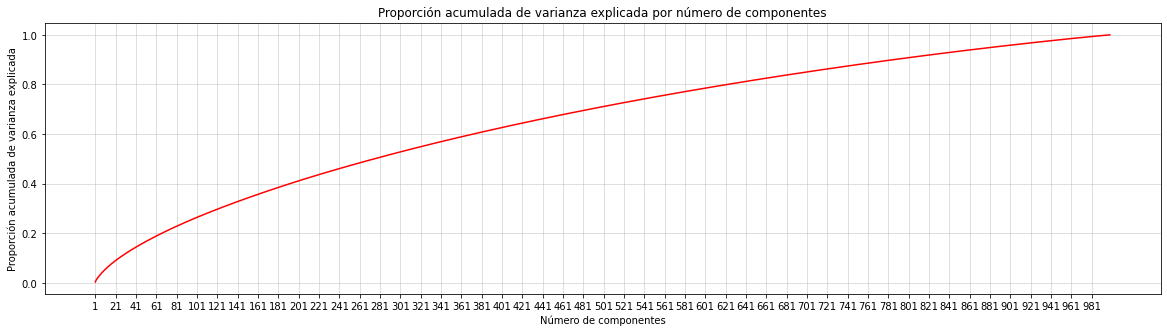

In [ ]:
plt.figure(figsize = (20,5))
g = sns.lineplot(y = svd_model.explained_variance_ratio_.cumsum(), x = range(1, len(svd_model.explained_variance_ratio_) + 1), color = 'red')
g.set_xticks(range(1, len(svd_model.explained_variance_ratio_) + 1, 20))
plt.title('Proporción acumulada de varianza explicada por número de componentes')
plt.ylabel('Proporción acumulada de varianza explicada')
plt.xlabel('Número de componentes')
plt.grid(alpha = 0.5)
plt.show()

Podemos notar el comportamiento esperado, en un principio, es decir, cuando no se tiene ninguna componente, considerar una nueva componente vale mucho la pena en el sentido que esta nueva componente o dimensión nos ayudará a explicar una gran proporción de varianza en los datos (relativamente hablando). Sin embargo, conforme se van considerando más y más componentes, la recompensa por considerar una más tiende a la nada. Esto implica que deberíamos buscar un número de componentes tal que se encuentre justo en la frontera antes de que deje de valer la pena considerar más componentes.

Una vez que tenemos claro lo anterior, podemos concluir que, tal vez, la gráfica anterior no posea suficiente evidencia del número "ideal" de componentes a considerar, por lo que a continuación decidimos graficar la proporción de varianza explicada aportada por cada una de las componentes de manera individual.

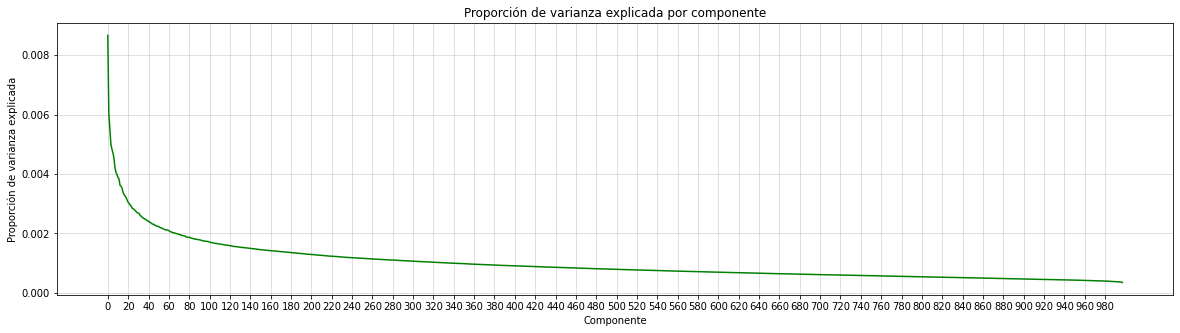

In [ ]:
plt.figure(figsize = (20,5))
g = sns.lineplot(y = np.diff(svd_model.explained_variance_ratio_.cumsum()), x = range(0, len(np.diff(svd_model.explained_variance_ratio_.cumsum()))), color = 'green')
g.set_xticks(range(0, len(np.diff(svd_model.explained_variance_ratio_.cumsum())), 20))
plt.title('Proporción de varianza explicada por componente')
plt.ylabel('Proporción de varianza explicada')
plt.xlabel('Componente')
plt.grid(alpha = 0.5)
plt.show()

Lo que dedujimos de la gráfica anterior es que nos gustaría considerar un número de componentes tal que se encuentre en el punto de inflexión de la curva de la proporción de varianza explicada por componente. No es dificil darse cuenta de que el punto de inflexión se encuentra en alrededor de 20 componentes. Esto lo podemos confirmar mediante la siguiente gráfica, que expone el comportamiento de lo que sería la segunda derivada o aceleración de la primera gráfica expuesta en este notebook.

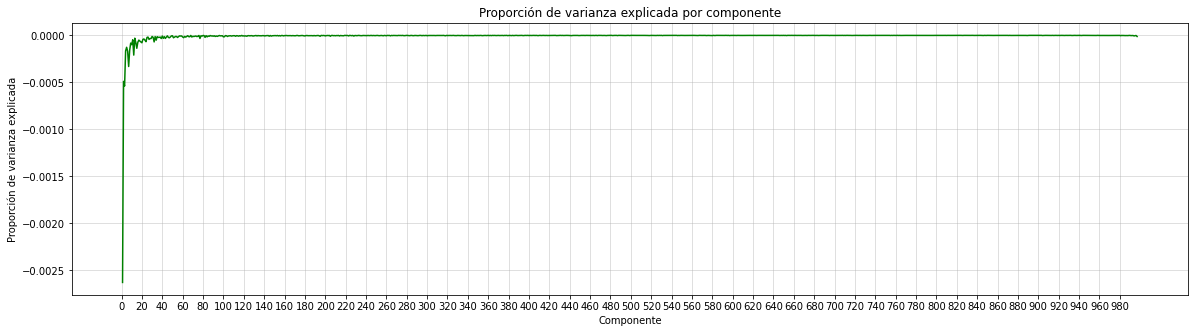

In [ ]:
plt.figure(figsize = (20,5))
g = sns.lineplot(y = np.diff(np.diff(svd_model.explained_variance_ratio_.cumsum())), x = range(1, len(np.diff(np.diff(svd_model.explained_variance_ratio_.cumsum()))) + 1), color = 'green')
g.set_xticks(range(0, len(np.diff(svd_model.explained_variance_ratio_.cumsum())), 20))
plt.title('Proporción de varianza explicada por componente')
plt.ylabel('Proporción de varianza explicada')
plt.xlabel('Componente')
plt.grid(alpha = 0.5)
plt.show()

Dicha gráfica nos ayuda a corroborar nuestra conclusión de que un buen número de componentes a considerar se encuentra muy cercano a 20, ya que para ese punto, la "aceleración" de la proporción de varianza explicada acumulada es casi cero, es decir, en ese punto esta última proporción tiende hacia una constante. Por lo tanto, decidimos utilizar únicamente 20 componentes.

Una vez que hemos encontrado un modo de resolver nuestro primer problema, estamos en condiciones de analizar cada una de las 20 componentes que hemos considerado, de tal modo que podamos identificar aquellas palabras que mejor resperesentan cada uno de los tópicos (en nuestro caso paritcular, como ya se mencionó anteriormente, cada tópico representa un género de películas y/o series). Lo que haremos a continuación, entonces, es construir una tabla para identificar este tipo de palabras para cada uno de los tópicos.

In [ ]:
terms = vectorizer.get_feature_names()
topics_description_df = pd.DataFrame()
topics_word_freq = dict()

for i, comp in enumerate(svd_model.components_[:20]):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)
    topics_description_df["Topic "+str(i)] = [sorted_terms[i][0] for i in range(30)]
    topics_word_freq["Topic "+str(i)] = {sorted_terms[i][0]:int(np.round(sorted_terms[i][1]*10000)) for i in range(len(sorted_terms))}
topics_description_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,like,bad,watch,good,story,series,bad,character,good,like,book,love,story,good,character,great,watch,story,really,really
1,good,watch,funny,great,book,episode,series,funny,episode,book,read,like,funny,story,kid,kid,like,like,scene,war
2,bad,good,great,actor,character,horror,episode,comedy,series,people,version,bad,horror,like,like,scene,great,time,watch,game
3,watch,like,love,performance,read,tv,year,laugh,bad,good,funny,scene,comedy,scene,child,action,look,play,story,play
4,time,really,think,character,watch,original,time,episode,love,think,kid,great,people,look,old,end,action,tell,performance,watch
5,character,waste,really,role,people,season,watch,joke,kid,play,novel,book,good,love,family,book,book,look,family,time
6,story,terrible,comedy,cast,think,fan,tv,series,girl,read,horror,look,laugh,music,story,guy,war,great,funny,action
7,really,think,laugh,story,life,like,book,main,family,look,old,music,life,song,year,time,story,waste,child,world
8,think,funny,like,play,love,dvd,war,plot,play,actor,comedy,character,great,action,horror,story,life,guy,episode,love
9,great,awful,episode,best,feel,effect,dvd,life,guy,say,child,series,tell,time,little,fight,scene,game,life,fun


Podemos ver que algunos de los tópicos se encuentran bastante bien definidos, por ejemplo, el tópico 5 parece representar el género de ciencia ficción, esto es fácil de deducir debido a las palabras más representativas de este tópico: "sci", "fi", "alien", "monster", "action", "effect", entre otras. Sin embargo, si que es posible encontar tópicos que no parezcan bien definidos. Entonces es aquí donde nos enfrentamos a otro problema, parece que la metodología usada hasta el momento no ha sido la mejor, por lo que más adelante probaremos hacer el modelado de tópicos siguiedo otra metodología.

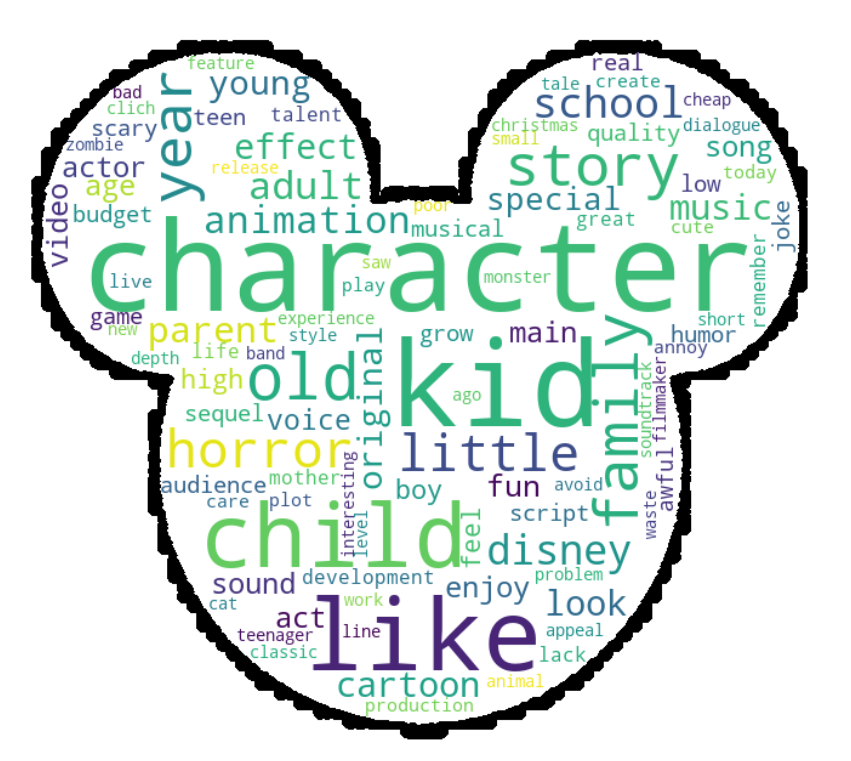

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import PIL
mask= np.array(PIL.Image.open('/content/mickey_6.jpg'))
wordcloud = WordCloud( mask=mask,background_color='white',contour_width=10, contour_color='black', max_words=100,relative_scaling=0.8,normalize_plurals=False,width=mask.shape[1],height=mask.shape[0]).generate_from_frequencies(topics_word_freq['Topic 14'])
plt.subplots(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

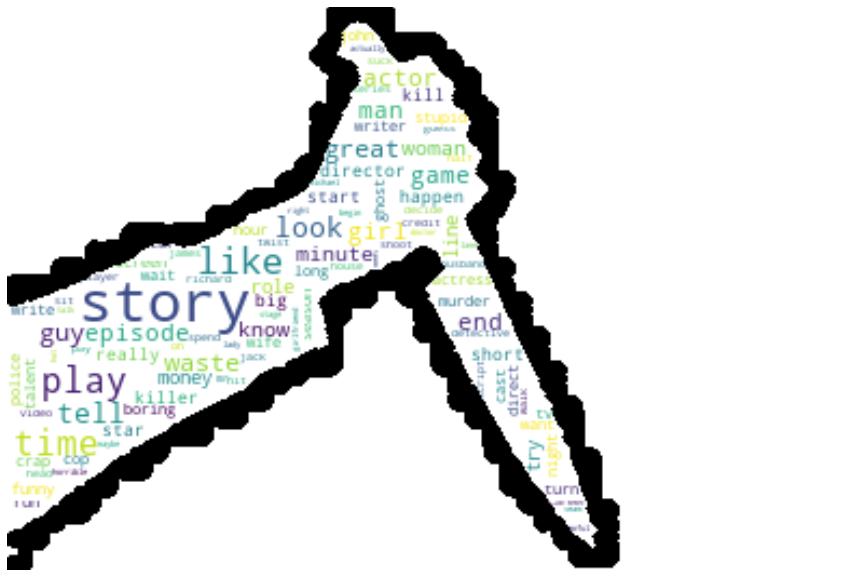

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import PIL
mask= np.array(PIL.Image.open('/content/cuchillo_6'))
wordcloud = WordCloud(mask=mask, background_color='white', contour_width=10, contour_color='black',width=1500,height=1300, max_words=100,relative_scaling=0.6,normalize_plurals=False).generate_from_frequencies(topics_word_freq['Topic 17'])
plt.subplots(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

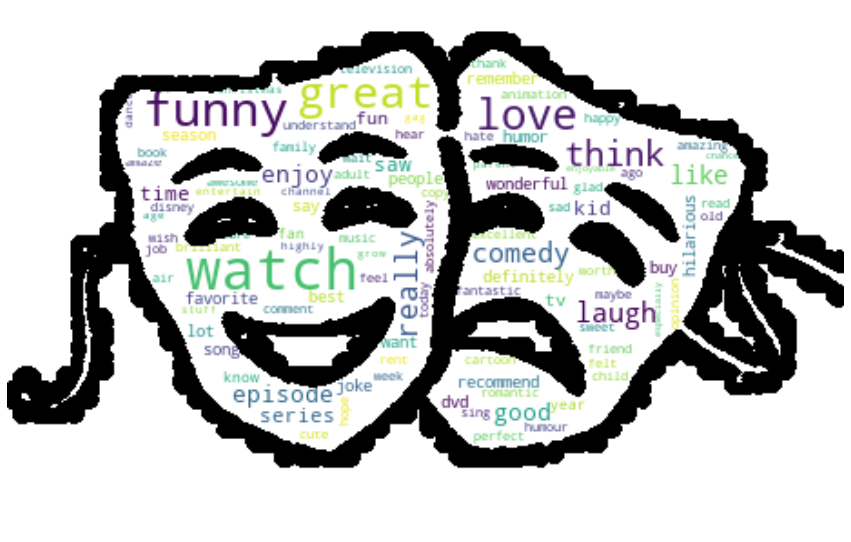

In [ ]:
mask= np.array(PIL.Image.open('/content/masks_2'))
wordcloud = WordCloud(mask=mask, background_color='white', contour_width=10, contour_color='black',width=mask.shape[1],height=mask.shape[0], max_words=100,relative_scaling=0.8,normalize_plurals=False).generate_from_frequencies(topics_word_freq['Topic 2'])
plt.subplots(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Palabras representativas del conjunto de tópicos

In [ ]:
from collections import defaultdict
fq= defaultdict( int )
for i, comp in enumerate(svd_model.components_[:20]):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    for w in sorted_terms:
      fq[w[0]] += 1

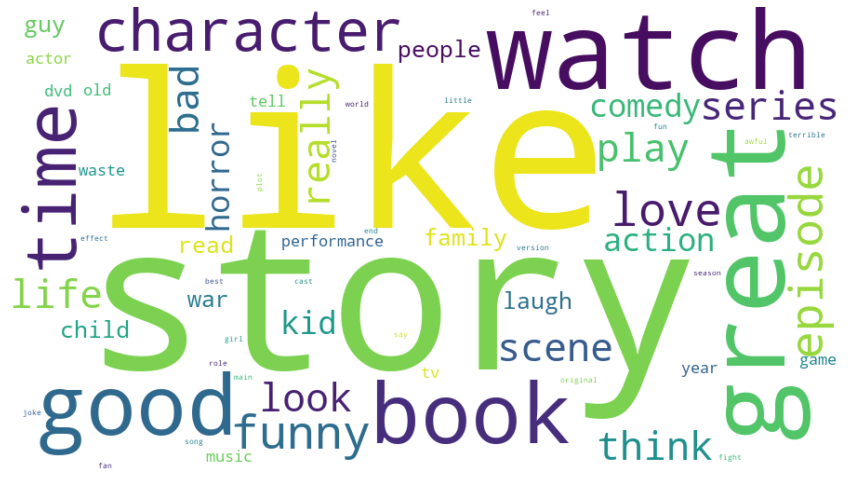

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
wordcloud = WordCloud( background_color='white', contour_width=1, contour_color='black',width=900,height=500, max_words=100,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(fq)
plt.subplots(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# NMF

NMF (Non-negative matrix factorization) factoriza aproximadamente una matriz $V$ en matrices $W, H$ de la forma:

$$ V = WH$$

Todas las matrices tienen entradas positivas; adicionalmente, tanto $W$ como $H$ tienen un tamaño mucho menor que $V$. 

Para entender por qué esto sirve para modelado de tópicos, consideremos una matriz de frecuencias de documentos $D$, de tamaño $m\times n$. Cada columna representa un documento, y cada fila una palabra. Si descomponemos $D$ de esta manera, $W$ tendrá tamaño $m\times p$, y $H$ tamaño $p\times n$. 

In [ ]:
from sklearn import decomposition
nmf_model = decomposition.NMF(n_components=20, random_state=1)
nmf_model.fit(X)
len(nmf_model.components_)

20

In [ ]:
terms = vectorizer.get_feature_names()
topics_description_df = pd.DataFrame()
topics_word_freq = dict()

for i, comp in enumerate(nmf_model.components_[:20]):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)
    topics_description_df["Topic "+str(i)] = [sorted_terms[i][0] for i in range(30)]
    topics_word_freq["Topic "+str(i)] = {sorted_terms[i][0]:int(np.round(sorted_terms[i][1]*10000)) for i in range(len(sorted_terms))}
topics_description_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,scene,bad,good,performance,funny,series,time,character,woman,watch,book,love,life,horror,kid,great,like,story,really,play
1,action,act,pretty,best,comedy,episode,waste,plot,man,want,read,fall,people,gore,child,job,look,tell,think,game
2,fight,terrible,job,work,laugh,season,long,main,end,worth,novel,beautiful,world,zombie,year,fun,say,line,say,role
3,sex,awful,acting,cast,joke,tv,money,development,kill,enjoy,version,song,war,effect,old,best,thing,true,know,actor
4,shot,acting,action,director,humor,original,saw,care,guy,think,adaptation,wonderful,real,budget,family,enjoy,lot,short,thing,actress
5,cut,script,plot,actor,hilarious,new,minute,feel,girl,dvd,write,romantic,documentary,scary,young,wonderful,people,end,saw,player
6,shoot,horrible,actor,star,fun,television,hour,end,try,tv,base,romance,live,low,parent,music,sound,tale,lot,star
7,use,plot,lot,music,moment,fan,spend,lack,murder,say,change,heart,american,fan,boy,lot,know,base,want,wife
8,sequence,guy,nice,excellent,stupid,dvd,come,interesting,start,minute,comic,music,human,flick,father,excellent,feel,interesting,happen,man
9,camera,stupid,think,script,gag,air,short,little,wife,friend,jane,favorite,way,monster,mother,action,think,beautiful,enjoy,stage


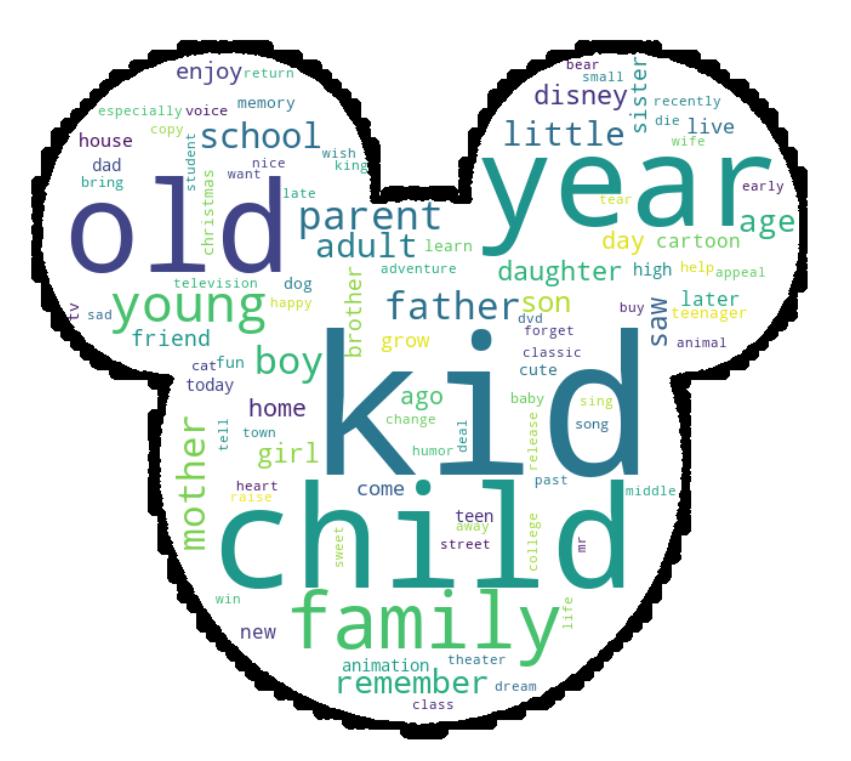

In [ ]:
mask= np.array(PIL.Image.open('/content/mickey_6.jpg'))
wordcloud = WordCloud( mask=mask,background_color='white',contour_width=10, contour_color='black', max_words=100,relative_scaling=0.8,normalize_plurals=False,width=mask.shape[1],height=mask.shape[0]).generate_from_frequencies(topics_word_freq['Topic 14'])
plt.subplots(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

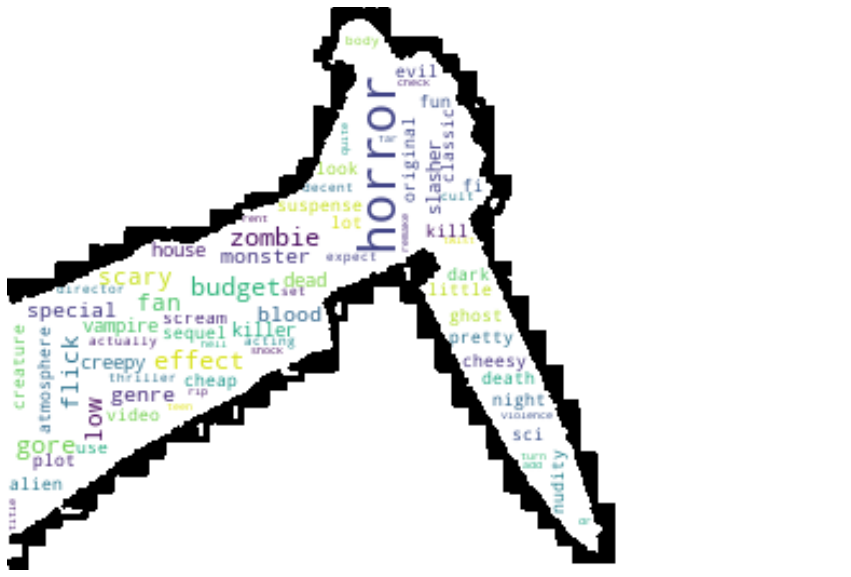

In [ ]:
mask= np.array(PIL.Image.open('/content/cuchillo_6'))
wordcloud = WordCloud(mask=mask, background_color='white', contour_width=4, contour_color='black',width=1500,height=1250, max_words=70,relative_scaling=0.6,normalize_plurals=False).generate_from_frequencies(topics_word_freq['Topic 13'])
plt.subplots(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

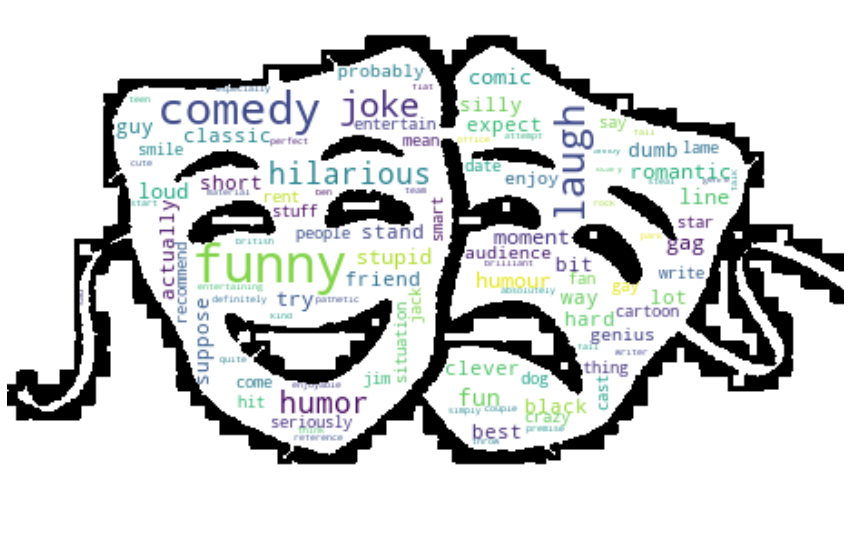

In [ ]:
mask= np.array(PIL.Image.open('/content/masks_2'))
wordcloud = WordCloud(mask=mask, background_color='white', contour_width=4, contour_color='black',width=1500,height=1250, max_words=100,relative_scaling=0.4,normalize_plurals=False).generate_from_frequencies(topics_word_freq['Topic 4'])
plt.subplots(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
fq_nmf= defaultdict( int )
for i, comp in enumerate(nmf_model.components_[:20]):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    for w in sorted_terms:
      fq_nmf[w[0]] += 1

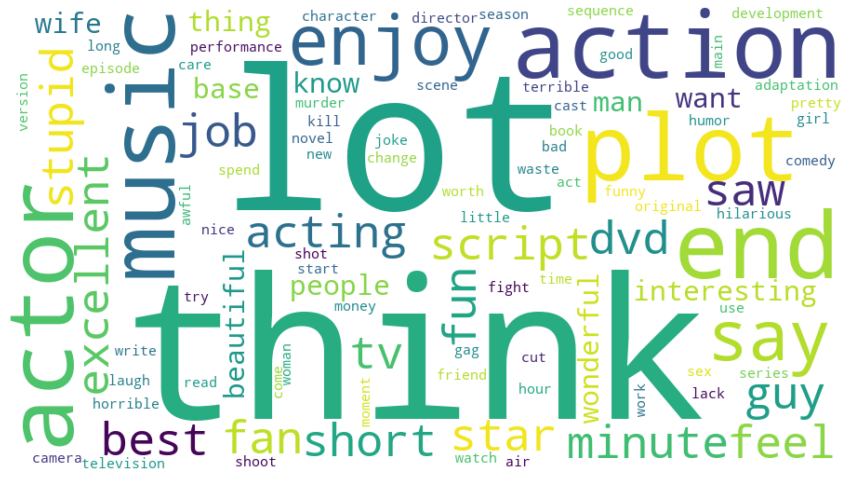

In [ ]:
wordcloud = WordCloud( background_color='white', contour_width=1, contour_color='black',width=900,height=500, max_words=100,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(fq_nmf)
plt.subplots(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
nmf_model.reconstruction_err_


In [ ]:
pip install fbpca

  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11376 sha256=1afc00bf8d8251f6ac3bfe78f19f1270eb899e3d3bdb4aff9fe787db6fabbdcc
  Stored in directory: /root/.cache/pip/wheels/93/08/0c/1b9866c35c8d3f136d100dfe88036a32e0795437daca089f70
Successfully built fbpca


In [ ]:
import fbpca

In [ ]:
%time u, s, v = decomposition.randomized_svd(X, 10)

CPU times: user 1.41 s, sys: 991 ms, total: 2.4 s
Wall time: 1.29 s


In [ ]:
%time u, s, v = fbpca.pca(X, 10)

CPU times: user 380 ms, sys: 358 ms, total: 738 ms
Wall time: 407 ms


In [ ]:
%time  decomposition.TruncatedSVD(X, 10)

CPU times: user 26 µs, sys: 2 µs, total: 28 µs
Wall time: 31.9 µs


TruncatedSVD(algorithm=10,
             n_components=<50000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 2274853 stored elements in Compressed Sparse Row format>,
             n_iter=5, random_state=None, tol=0.0)

In [ ]:
%time u, s, v = fbpca.pca(X, 10)

CPU times: user 397 ms, sys: 503 ms, total: 899 ms
Wall time: 477 ms


In [ ]:
%time  decomposition.NMF(X, 10)

CPU times: user 51 µs, sys: 3 µs, total: 54 µs
Wall time: 58.2 µs


NMF(alpha=0.0, beta_loss='frobenius', init=10, l1_ratio=0.0, max_iter=200,
    n_components=<50000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 2274853 stored elements in Compressed Sparse Row format>,
    random_state=None, shuffle=False, solver='cd', tol=0.0001, verbose=0)